## Occupation Classification
  - Traditional: Logistic Regression (TF-IDF)
  - Neural: Fine-tuned BERT/RoBERTa
  - Metrics: Accuracy, Precision, Recall, F1

### Data Loading

In [1]:
import pandas as pd
data = pd.read_csv('../../data/dataset3/ted_talks_en.csv')
data = data[['occupations', 'transcript']].dropna().reset_index(drop=True)
data.head()

,occupations,transcript
0,{0: ['climate advocate']},"Thank you so much, Chris. And it's truly a gre..."
1,{0: ['global health expert; data visionary']},"About 10 years ago, I took on the task to teac..."
2,{0: ['technology columnist']},"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,{0: ['activist for environmental justice']},If you're here today — and I'm very happy that...
4,"{0: ['author', 'educator']}",Good morning. How are you? (Audience) Good. It...


### Data Preprocessing

In [2]:
from sklearn.model_selection import train_test_split
import ast
import re

clean_data = data.copy()

# extract only occupations of the main speaker
def extract_first_occupation(x):
    if pd.isna(x):
        return []
    if isinstance(x, (list, tuple)):
        return [str(x[0])] if x else []
    if not isinstance(x, str):
        return []
    s = x.strip()
    # try to parse as literal
    try:
        val = ast.literal_eval(s)
        if isinstance(val, dict):
            first_val = next(iter(val.values()))
            if isinstance(first_val, (list, tuple)):
                return [str(first_val[0])] if first_val else []
            return [str(first_val).split(',')[0].strip()] if first_val else []
        if isinstance(val, (list, tuple)):
            return [str(val[0])] if val else []
        if isinstance(val, str):
            return [val.split(',')[0].strip()]
    except Exception:
        pass
    # fallback: check for brackets
    m = re.search(r'\[(.*?)\]', s)
    if m:
        inside = m.group(1)
        parts = [p.strip().strip('\'"') for p in re.split(r',\s*', inside) if p.strip()]
        return [parts[0]] if parts else []
    # fallback: split by comma
    parts = [p.strip().strip('\'"') for p in re.split(r',\s*', s) if p.strip()]
    return [parts[0]] if parts else []

PATTERNS = {
    'author': ['author', 'writer', 'novelist', 'biographer', 'poet'],
    'researcher': ['researcher', 'scientist', 'research', 'physicist', 'chemist', 'biologist'],
    'academic': ['professor', 'lecturer', 'associate professor', 'assistant professor', 'academic'],
    'engineer': ['engineer', 'developer', 'programmer', 'software', 'architect'],
    'entrepreneur': ['entrepreneur', 'founder', 'ceo', 'co-founder', 'startup'],
    'artist': ['artist', 'painter', 'sculptor', 'illustrator', 'designer'],
    'musician': ['musician', 'composer', 'singer', 'songwriter'],
    'actor': ['actor', 'actress', 'performer'],
    'journalist': ['journalist', 'reporter', 'editor'],
    'politician': ['politician', 'minister', 'senator', 'mayor'],
}

def map_to_coarse(label: str) -> str:
    if not isinstance(label, str) or not label.strip():
        return 'other'
    s = label.lower()
    # remove common modifiers
    s = re.sub(r'(\baward[-\s]?winning\b|\bbest[-\s]?selling\b|\bformer\b|\bsenior\b|\bchief\b|\blead\b)', ' ', s)
    s = re.sub(r'[^a-z0-9\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    # check patterns
    for coarse, kws in PATTERNS.items():
        for kw in kws:
            if kw in s:
                return coarse
    # fallback: use last word as coarse label
    parts = s.split()
    return parts[-1] if parts else 'other'

clean_data['occupations'] = clean_data['occupations'].apply(extract_first_occupation)

# Remove entries with empty occupations
clean_data = clean_data[clean_data['occupations'].map(lambda x: bool(x))].reset_index(drop=True)

clean_data['transcript'] = clean_data['transcript'].str.replace(r'\[.*?\]', '', regex=True)
clean_data['transcript'] = clean_data['transcript'].str.replace(r'\s+', ' ', regex=True).str.strip()
clean_data['occupations'] = clean_data['occupations'].map(
    lambda lst: [map_to_coarse(lst[0])] if lst else []
)
top_k = 30
counts = clean_data['occupations'].explode().value_counts()
top_labels = set(counts.nlargest(top_k).index.tolist())

def keep_top_or_other(lst):
    if not lst:
        return ['other']
    lab = lst[0]
    return [lab] if lab in top_labels else ['other']

clean_data['occupations'] = clean_data['occupations'].map(keep_top_or_other)
clean_data = clean_data[clean_data['occupations'].map(bool)].reset_index(drop=True)
print("Coarse occupation counts:\n", clean_data['occupations'].explode().value_counts())

train_data, test_data = train_test_split(clean_data, test_size=0.2, random_state=63)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")
print(clean_data.head())


Coarse occupation counts:
 occupations
other             1072
researcher         466
author             289
artist             255
entrepreneur       160
engineer           144
journalist         129
activist           120
expert              98
psychologist        71
economist           63
advocate            54
inventor            50
educator            48
musician            43
photographer        38
academic            33
technologist        31
philosopher         30
filmmaker           28
visionary           28
physician           25
scholar             25
politician          24
actor               24
consultant          24
roboticist          23
theorist            23
strategist          22
anthropologist      22
historian           21
Name: count, dtype: int64
Train size: 2786, Test size: 697
   occupations                                         transcript
0   [advocate]  Thank you so much, Chris. And it's truly a gre...
1  [visionary]  About 10 years ago, I took on the task to

### Traditional Model: Logistic Regression with TF-IDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer

# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
log_reg = LogisticRegression(max_iter=1000)
multi_target_log_reg = MultiOutputClassifier(log_reg)

pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('clf', multi_target_log_reg)
])

# Prepare training data
mlb = MultiLabelBinarizer()
X_train = train_data['transcript']
y_train = mlb.fit_transform(train_data['occupations'])    # fit on train
X_test = test_data['transcript']
y_test = mlb.transform(test_data['occupations'])          # transform test to same columns
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Train the model
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0))

y_train shape: (2786, 31), y_test shape: (697, 31)
Logistic Regression Classification Report:
                precision    recall  f1-score   support

      academic       0.00      0.00      0.00         7
      activist       0.00      0.00      0.00        29
         actor       0.00      0.00      0.00         3
      advocate       0.00      0.00      0.00         6
anthropologist       0.00      0.00      0.00         4
        artist       0.00      0.00      0.00        42
        author       0.00      0.00      0.00        56
    consultant       0.00      0.00      0.00         7
     economist       0.00      0.00      0.00        14
      educator       0.00      0.00      0.00        10
      engineer       0.00      0.00      0.00        24
  entrepreneur       0.00      0.00      0.00        37
        expert       0.00      0.00      0.00        14
     filmmaker       0.00      0.00      0.00         5
     historian       0.00      0.00      0.00         6
      inv

### Neural Model: Fine-tuned BERT

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Prepare labels
labels_train = [lst[0] for lst in train_data['occupations'].tolist()]
labels_test = [lst[0] for lst in test_data['occupations'].tolist()]

le = LabelEncoder()
y_train_ids = le.fit_transform(labels_train)   # ndarray shape (n_samples,)
y_test_ids = le.transform(labels_test)

num_labels = len(le.classes_)

# Define Dataset
class OccupationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = int(self.labels[idx])            # 单个整数
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)   # long for CrossEntropy
        return item

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = OccupationDataset(train_data['transcript'].tolist(), y_train_ids, tokenizer)
test_dataset = OccupationDataset(test_data['transcript'].tolist(), y_test_ids, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
epochs = 3
avg_losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)          # shape (batch,)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    avg_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 2.6209
Epoch 2/3, Loss: 2.2533
Epoch 3/3, Loss: 1.8899


In [10]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].cpu().numpy()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
print(f"BERT Model - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

print("Label classes:", le.classes_)

BERT Model - Accuracy: 0.3816, Precision: 0.3409, Recall: 0.3816, F1 Score: 0.3178
Label classes: ['academic' 'activist' 'actor' 'advocate' 'anthropologist' 'artist'
 'author' 'consultant' 'economist' 'educator' 'engineer' 'entrepreneur'
 'expert' 'filmmaker' 'historian' 'inventor' 'journalist' 'musician'
 'other' 'philosopher' 'photographer' 'physician' 'politician'
 'psychologist' 'researcher' 'roboticist' 'scholar' 'strategist'
 'technologist' 'theorist' 'visionary']


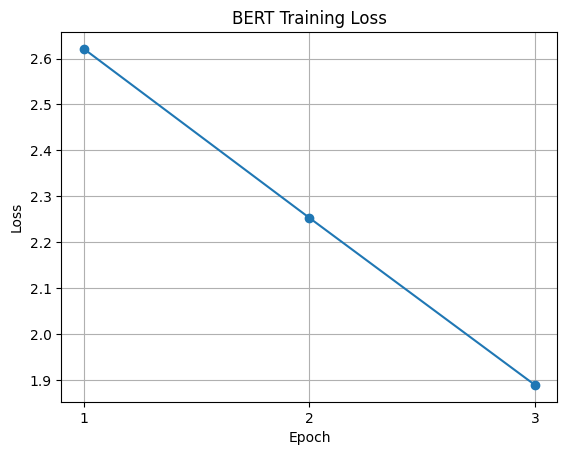

In [11]:
import matplotlib.pyplot as plt
# Plot training loss
plt.plot(range(1, epochs+1), avg_losses, marker='o')
plt.title('BERT Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(1, epochs+1))
plt.grid()
plt.show()

In [13]:
# Save the fine-tuned model
model.save_pretrained('../../models/dataset3/bert_occupation_classifier')
tokenizer.save_pretrained('../../models/dataset3/bert_occupation_tokenizer')

('../../models/dataset3/bert_occupation_tokenizer\\tokenizer_config.json',
 '../../models/dataset3/bert_occupation_tokenizer\\special_tokens_map.json',
 '../../models/dataset3/bert_occupation_tokenizer\\vocab.txt',
 '../../models/dataset3/bert_occupation_tokenizer\\added_tokens.json')